In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [4]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [5]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...


C:\Users\edizy\AppData\Local\Temp\ipykernel_3372\4062928930.py:41: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfile.extractall(path=path)


Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


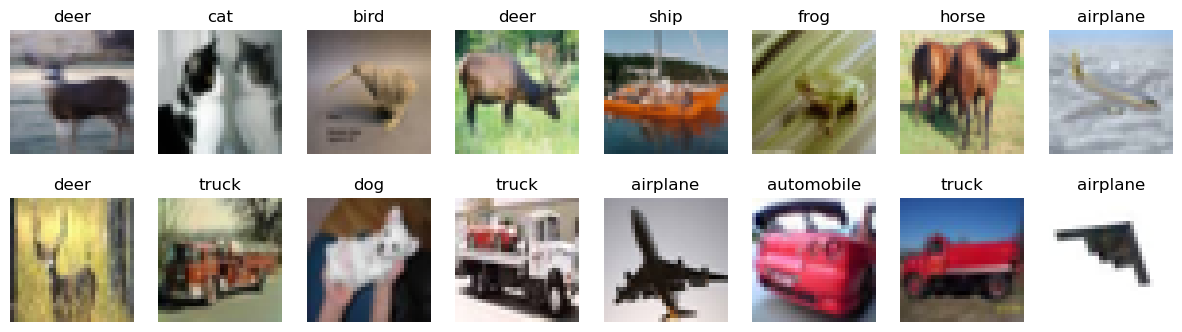

In [6]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [7]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [8]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [34]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    # Pooling layer to reduce spatial dimensions
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer with 128 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output to pass into fully connected layers
    model.add(Flatten())

    # Fully connected layer with 128 neurons
    model.add(Dense(128, activation='relu'))
    # Dropout layer for regularization
    model.add(Dropout(0.5))

    # Output layer with 10 neurons (one for each CIFAR-10 class)
    model.add(Dense(10))
    ### END STUDENT CODE ### 

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax")) 

    return model

In [36]:
import os
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras

# Adjusted parameters to improve training
INIT_LR = 1e-3  # Increased learning rate for faster convergence
BATCH_SIZE = 32  # Batch size for regularization
EPOCHS = 30  # Increased epochs to allow more learning

K.clear_session()  # Clear default graph

model = make_model()  # Define our model

# Path to weights file
weights_path = "myweights2.weights.h5"

# Check if previous weights exist and load them
if os.path.exists(weights_path):
    try:
        model.load_weights(weights_path, by_name=True)  # Load weights by name to skip mismatched layers
        print("Loaded previous weights!")
    except ValueError as e:
        print(f"Error loading weights: {e}")
else:
    print("No weights file found. Starting from scratch.")

# Prepare model for fitting
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Track validation loss
    patience=6,  # Allow more epochs to improve
    restore_best_weights=True  # Keep the best weights when stopping early
)

# Fit model (continue training from previous state)
model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[early_stopping]  # Apply early stopping
)

# Save updated weights after training
model.save_weights(weights_path)
print("Saved updated weights!")


Error loading weights: Invalid keyword arguments: {'by_name': True}
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - accuracy: 0.2905 - loss: 1.8975 - val_accuracy: 0.5408 - val_loss: 1.2795
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.5099 - loss: 1.3663 - val_accuracy: 0.6021 - val_loss: 1.1187
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - accuracy: 0.5863 - loss: 1.1575 - val_accuracy: 0.6497 - val_loss: 0.9858
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - accuracy: 0.6427 - loss: 1.0144 - val_accuracy: 0.6848 - val_loss: 0.9034
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.6814 - loss: 0.9150 - val_accuracy: 0.7114 - val_loss: 0.8325
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7061 - loss: 0.8350 - val_accuracy: 0.7192 - val_loss: 0.8082
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.7307 - loss: 0.7703 - val_accuracy: 0.7249 - val_loss: 0.7871
Epoch 8/

In [26]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

c:\Users\edizy\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 3 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization, built=True>:

Layer 'batch_normalization' expected 4 variables, but received 0 variables during loading. Expected: ['gamma', 'beta', 'moving_mean', 'moving_variance']

List of objects that could not be loaded:
[<BatchNormalization name=batch_normalization, built=True>, <BatchNormalization name=batch_normalization_1, built=True>, <BatchNormalization name=batch_normalization_2, built=True>]

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


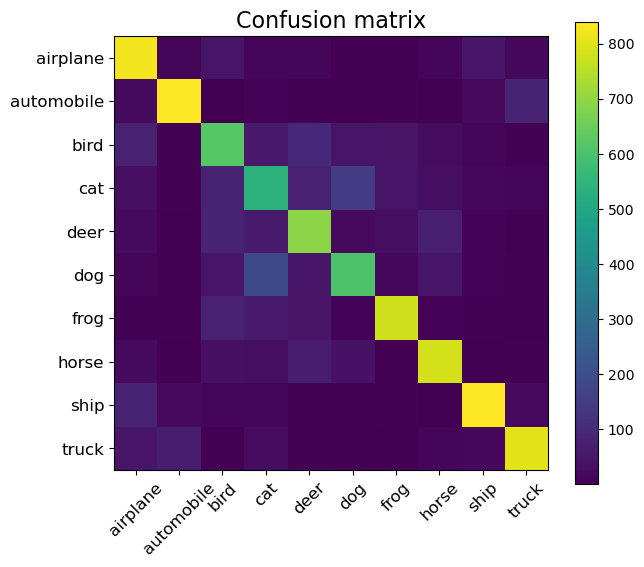

Test accuracy: 0.7325


In [37]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

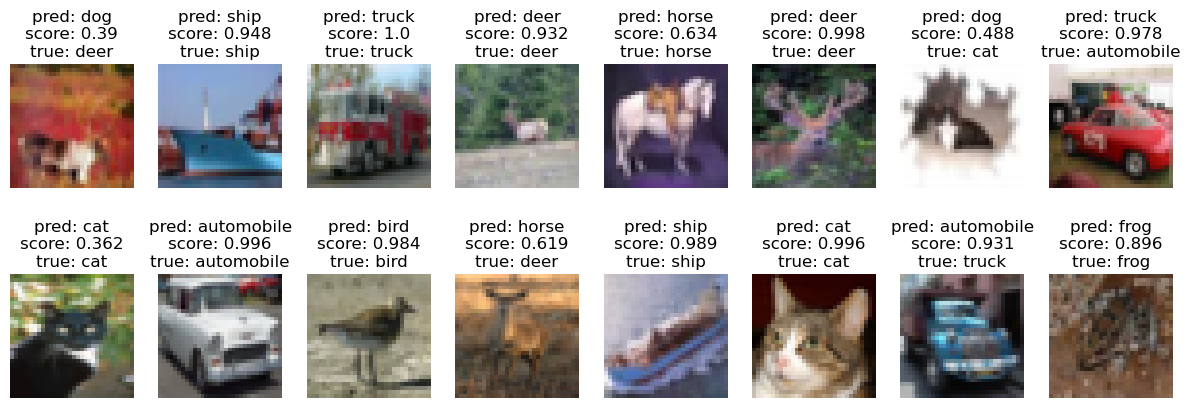

In [38]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




The code trains a CNN model on the CIFAR-10 dataset with several adjustments. The learning rate was set to 1e-3 to speed up convergence, and the batch size was chosen as 32 for better generalization. The number of epochs was increased to 30 to allow the model more time to learn, and early stopping was used to prevent overfitting by halting training when the validation loss no longer improves. Weights from a previous run are loaded if available to resume training.

However, the model is still showing signs of overfitting, with the test accuracy plateauing at 74%. This suggests that more advanced regularization techniques or data augmentation could be necessary to further improve generalization.

in the previous itterations of the code the accuracy of 76 percent was achieved however same problem of overfitting was observed. After the canges to the main network model the final model was achieved.